Name: Feiyang Li  
ID: 23202564

#Lab 2: Image Filtering
In this lab we will demonstrate filtering of images with a gaussian kernel. We will see how to perform linear filtering of images using separable convolution which is more computationally efficient than convolution with a single large kernel.






##House Keeping
Import packages

In [14]:
import numpy as np
import urllib.request
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy import signal
from tqdm import tqdm
import time

Read and display a test Image

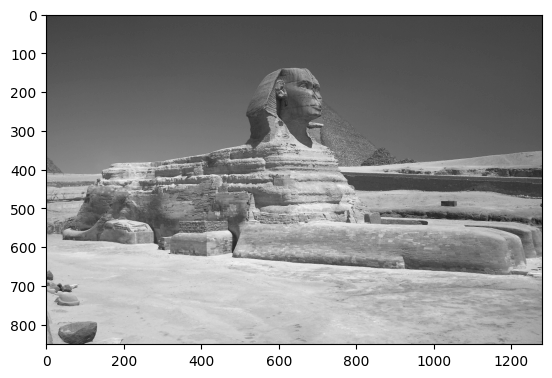

In [15]:
#image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/23_Ptica_i_Globus.jpg/945px-23_Ptica_i_Globus.jpg"
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f6/Great_Sphinx_of_Giza_-_20080716a.jpg/2560px-Great_Sphinx_of_Giza_-_20080716a.jpg"
# Function to read images from the Web.
def url_to_image(url):
	resp = urllib.request.urlopen(url)
	temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
	temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB here..
	return temp_image

def read_image():
   # read Image
   sf =2
   image = url_to_image(image_url)
   #Scale Image by sf = 2
   x,y,z = np.shape(image)
   image_scale = cv2.resize(image, dsize=(int(y/sf), int(x/sf)), interpolation=cv2.INTER_CUBIC)
   #Convert to Greyscale
   gray = cv2.cvtColor(image_scale, cv2.COLOR_BGR2GRAY)
   return image_scale,gray

image_scale,gray = read_image()
plt.imshow(gray,'gray')

# A: 1 Dimensional Kernel
Lets first build a function `gauss_kernel` to output a 1D gaussian kernel for any standard deviation value $\sigma$. We will use the sampled approximation for the gaussian kernel and obtain sampled values from equation for the gaussian probabilty density function. The equation for the 1D guassian PDF with zero mean and standard deviation $\sigma$ is given [here](https://www.sci.utah.edu/~gerig/CS7960-S2010/handouts/04%20Gaussian%20derivatives.pdf). It is necessary to obtain the kernel over a sufficient range of points, so that the function has time to decay to zero. The rule of thumb is that the range $M$ over which we need to evaluate the kernel should be $M=6\sigma+1$. We obtain values for the kernel at integer values $x$ in the over the range $x=[-M/2,M/2]$


> Hint: use the numpy [arange](https://numpy.org/doc/stable/reference/generated/numpy.arange.html) method to generate all necessary over the range $[-M/2,M/2]$



In [16]:
# Complete the 1D Gaussian Kernel Function
def gauss_kernel(sigma):
    """
    sigma: Parameter controlling Gaussian blur
    gauss_1d: output array containing kernel
    """
    # Work out necessary kernel size and range to generate gaussian over.
    M = 6 * sigma + 1
    x = np.arange(-M/2, M/2, dtype=int)

    # Implement the 1D guassian using the PDF equation
    gauss_1d = np.exp(-(x**2) / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))


    return gauss_1d

If we run the completed `gauss_kernel` function for a $\sigma = 10$ and get it's shape we see that it is one dimensional (i.e. the shape will be returned in the form (n,) )

kernel shape = (61,)


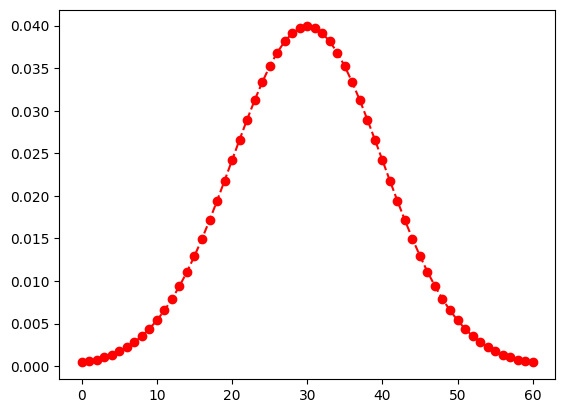

In [17]:
# Call the function for a sigma size of 10
gauss_1d=gauss_kernel(10)

# Print the shape of the kernel
print('kernel shape =',np.shape(gauss_1d))

# plot a graph of kernel
plt.plot(gauss_1d,'ro--')

# B. Creating a 2D kernel for image processing
For image processing we require a 2D kernel. We can easily create a 2D kernel by getting the outer product of two 1D kernels. As we can see in the figure below, we get the outer product of two 1D (column) arrays $u$ and $v$ by matrix multiplying $uv^T$. The outer product of two 1D vectors (or numpy arrays) will give an (n x n) 2D array.  

![](https://media.cheggcdn.com/study/8a3/8a3993b3-d3e3-4885-a922-78c73a0f1d76/DC-1776V3.png)


Rather than performing matrix multiplication we can simply get the outer product of the 1D kernels using the numpy
[outer](https://numpy.org/doc/stable/reference/generated/numpy.outer.html) function.  The outer function will automatically transpose one of the vectors before performing the matrix multiplication. In the code cell below we will form a 2D gaussian kernel using the gauss_1d we created above. (We note that we used a $\sigma =10$ when creating this kernel)


2D gaussian kernel shape = (61, 61)


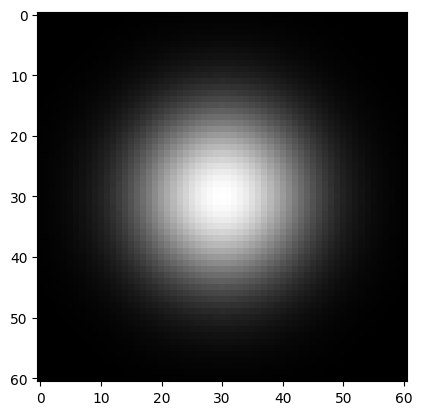

In [18]:
# Obtain the outer product of 1D Gaussian Kernels
gauss_2d= np.outer(gauss_1d, gauss_1d)

# Obtain an intensity plot of the 2D kernel
plt.imshow(gauss_2d,'gray')
print('2D gaussian kernel shape =',np.shape(gauss_2d))

#C. Convolving the kernel
We will now convolve the gaussian kernel with the test image called `gray`. We will use the SciPy [signal.convolve2D](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html) function to perform convolution. We should see that the image is blurred as expected with a gaussian kernel. We also obtain the time taken for later comparision with separable convolution. We can set mode = 'same', so that the convolved output image is the same size as the input image.  
We will record and display the time taken for the convolution operation, we set the $\sigma=10$ earlier so the resulting kernel is large and it will take significant time to convolve this with the image due to the amount of computation.

Time taken to compute convolution = 14.43225383758545 seconds ---


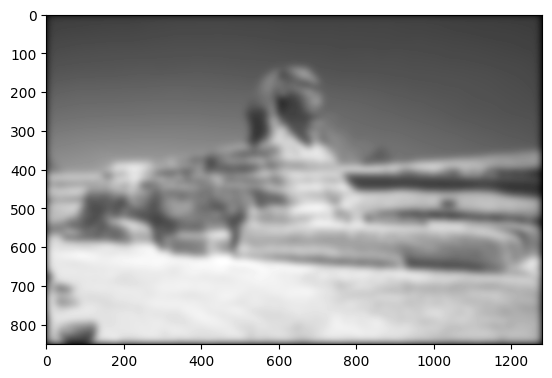

In [19]:
# Use time method to measure how long convolution operation takes
start_time = time.time()

# Perform convolution with signal convolve.
gauss_conv_img = signal.convolve2d(gray, gauss_2d, mode='same')

# Print Time Elaspsed
print("Time taken to compute convolution = %s seconds ---" % (time.time() - start_time))

# Plot result of convolution
plt.imshow(gauss_conv_img,'gray')

#D. Separable Convolution
The convolution in the last step took a long time to run, due to the large size of the kernel and large image. We can speedup the time to perform convolution by using separable convolution. For any 2D kernel that is symmetrical (e.g. gaussian kernel) or any other kernel that we know is formed from two 1D arrays, we can apply separable convolution as shown in the diagram.

Convolution takes place separately (sequentially) with each of the 1D kernels (used to make our 2D kernel), and we will get the same result as convolution with the original 2D kernel.

![](https://iq.opengenus.org/content/images/2021/06/ssc2.PNG)

The question that you should be asking is why the separable convolution is equivalent to the regular 2D convolution? To answer this we will need two important mathematical relationships. Firstly the diagram below we can see that the outer product is actually equivalent to convolution between the 1D kernels!

![](https://github.com/tonyscan6003/etivities/blob/main/section1-Page-10.jpg?raw=true)


The second relation that we need is that convolution is commutative. This means the order of convolution operations doesn't matter. Therefore It doesn't matter mathematically if we preform convolution on the image with the 2D gaussian kernel or we instead use separable convolution. In both cases we actually are carrying out 2 convolutions, only the order of our convolutions is different. In the original case (section C) we got the outer product of our kernels which is the same as a convolution, and we then convolve this 2D kernel with the image, which is our second convolution. $(G_{col} \ast G_{row}) \ast I$ where $G_{row}$ and $G_{col}$ is the 1 dimension gaussian kernel (row and column vectors) and $I$ is the 2D image.
In separable convolution we take advantage of the fact the commutative property of convolution and convolve the image with the column kernel and then the row kernel. $(G_{col} \ast I) \ast G_{row}$. The approaches are mathematically equivalent, but it turns out to be more computationally efficient to complete 1D convolutions with the image.   




###D1.
Prior to carrying out the separable convolution we need to explicitly define the 1 dimension `gauss_1d` kernel as an n x 1 column array and also obtain transpose which is a 1 x n array.
 We can add an additional dimension using [np.expand_dims](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html). We can get the transpose any array using [np.transpose](https://numpy.org/doc/stable/reference/generated/numpy.transpose.html).


In [20]:
# Explicitly define the gauss_1d array as a n x 1 array
gauss_1d_col = np.expand_dims(gauss_1d, axis=1)

# Print Shape
print('The 1D kernel gauss_1d_col has shape =',np.shape(gauss_1d_col))

# Obtain the transpose of gauss_1d array (will be 1 x n array)
gauss_1d_row = np.transpose(gauss_1d_col)

# Print Shape
print('The 1D kernel gauss_1d_row has shape =',np.shape(gauss_1d_row))

The 1D kernel gauss_1d_col has shape = (61, 1)
The 1D kernel gauss_1d_row has shape = (1, 61)


###D2.
We will now go ahead and perform separable convolution with the 1D kernels. As shown in the separable convolution example above we will first convolve the image with the column vector (n x 1) and then convolve the intermediate image with the row vector ( 1 x n). (We note that we could change the order of the convolutions and get the same result)

We should see the same blurred image as produced in part C. Importantly we should also see that the time taken to perform this separable convolution was much faster than directly convolving with the 2D gaussian!

Time taken to compute separable convolution = 0.8404586315155029 seconds ---


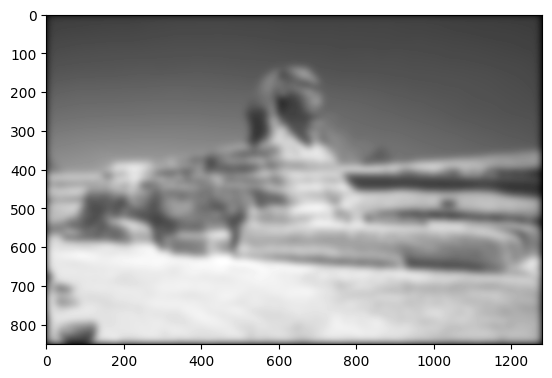

In [21]:
# load image again (to remove previous blur)
image_scale,gray = read_image()

# Start/Record Time for Separable Convolution
start_time = time.time()

# Apply first convolution with (n x 1) colunm vector
int_img = signal.convolve2d(gray, gauss_1d_col, mode='same')
# Apply second convolution (1 x n) row vector
gauss_conv_img = signal.convolve2d(int_img, gauss_1d_row, mode='same')



# Print Elapsed Time and plot image
print("Time taken to compute separable convolution = %s seconds ---" % (time.time() - start_time))
plt.imshow(gauss_conv_img,'gray')